1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
#!pip show catboost #- узнать версию конкретного пакета
#!pip install catboost
#!pip install scikit-uplift catboost==0.24.2 -U #установка uplift для конкретной версии catboost
#!pip install causalml

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
df = pd.read_csv('/gdrive/MyDrive/data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [4]:
# переименуем стобцы воздействие, таргет
df = df.rename(columns={'offer':'treatment', 'conversion':'target'})
# представим категории признака treatment в бинарном виде
df['treatment'] = df['treatment'].map({'Buy One Get One':1,'Discount':1, 'No Offer' :0})

In [5]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [6]:
# Посмотрим на баланс таргета в зависимости от воздействия
df.groupby('treatment')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


Разделим на тренировочный и тестовый

In [7]:
indices = df.index
# Раделим индексы на тренировочные и тестовые
indices_train, indices_test = train_test_split(df.index, test_size = 0.3, random_state = 42)

In [8]:
# Разбиение на трейн и тест
X_train = df.loc[indices_train, :].drop(columns = ['target','treatment'])
y_train = df.loc[indices_train, 'target']
treat_train = df.loc[indices_train, 'treatment']

X_test = df.loc[indices_test, :].drop(columns = ['target','treatment'])
y_test = df.loc[indices_test, 'target']
treat_test =  df.loc[indices_test, 'treatment']

In [9]:
X_train.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
9656,7,434.35,1,0,Urban,1,Web
63037,1,376.59,1,0,Surburban,0,Multichannel
31405,3,140.34,0,1,Urban,1,Phone


У нас есть несколько категориальных признаков, но чтобы не заморачиваться c OHE - работать будем на основе Catboost

Определим их в отдельный список

In [10]:
cat_features = ['zip_code','channel']

Создадим словарь для отслеживания результатов

In [11]:
models_results = {'approach' : [], 
                  'uplift@10%': [],
                  'uplift@20%': []}



Позаимствую функцию) втроенную не проверял, но поверю, что работает некорректно

In [12]:
from sklearn.utils.validation import check_consistent_length
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

### 1. SoloModel

In [13]:
from sklift.metrics import uplift_at_k
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [14]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
# в фит мы должны передать 3 аргумента
# X - описание векторов, y которые отвечают на результат после того как мы сделали treatment, и само наличие treatment
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})
# делаем предикты тестового набора, которые впоследствии отсортируем от более желательных к менее желательным
uplift_sm = sm.predict(X_test)
# метрика для uplitf
# передаем валидационные y, предсказанный uplift для тех-же самых объектов, информацию о воздейтсвии на те-же объекты
# k - оценка в процентах, сколько брать по uplift
sm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

# и добавим значения в наш словарь
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_1)
models_results['uplift@20%'].append(sm_score_2)

Теперь посмотрим на графики

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4261d0c650>,
      dtype=object)

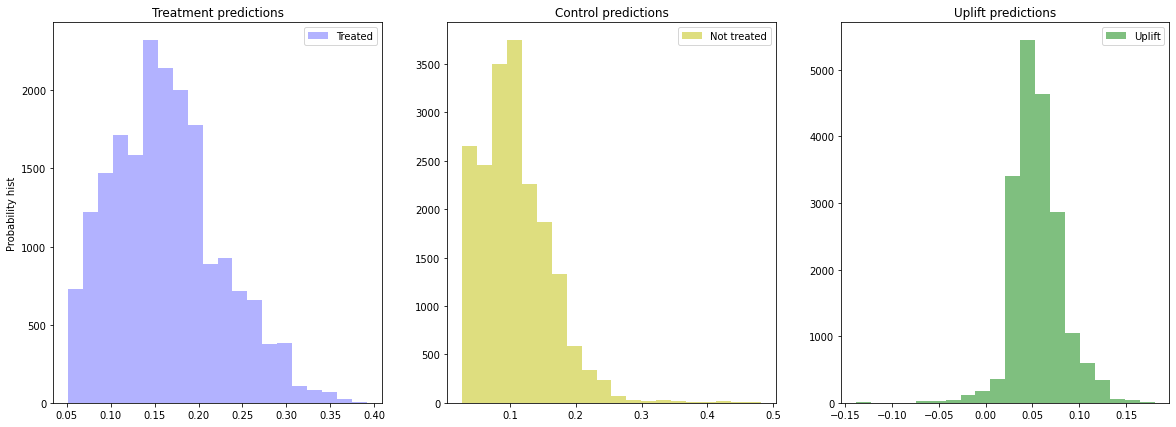

In [15]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отобразим распределения вероятностей и их разность (uplift)
plot_uplift_preds_(sm_trmnt_preds , sm_ctrl_preds, bins=20)

### 2. Трансформация класса
### !!!Вот тут у меня вопрос. Читал, что данный метод не рекомендуют использовать при дисбалансе, а у нас дисбаланс почти в 2 раза. Что-то подказывает, что в подобных задачах балансировка вообще не имеет смысла

In [16]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransform')
models_results['uplift@10%'].append(ct_score_1)
models_results['uplift@20%'].append(ct_score_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  after removing the cwd from sys.path.


### 3. Решение с двумя независимыми моделями

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4260df2050>,
      dtype=object)

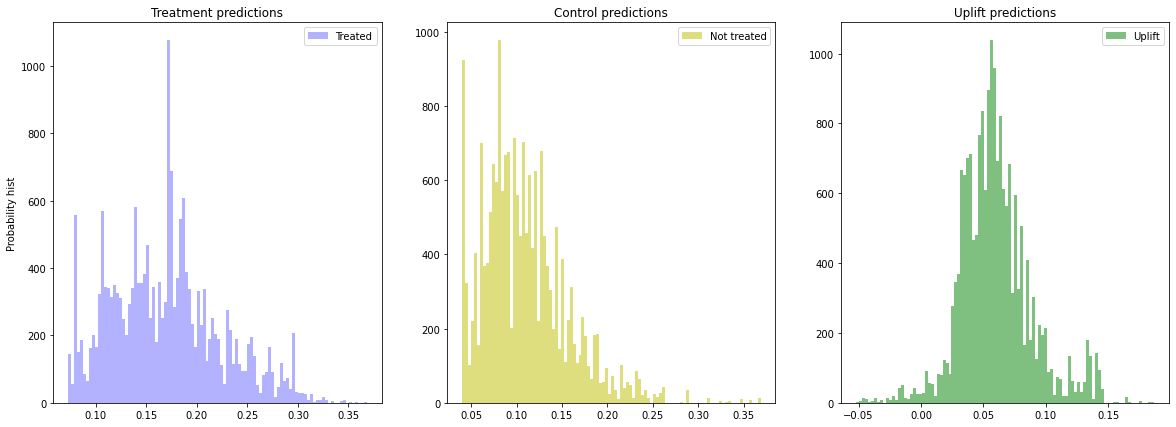

In [17]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla' # это метод 2х независимых моделей
)

# Тренируем, также передавая X, результат воздействия, наличие воздействия
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_1)
models_results['uplift@20%'].append(tm_score_2)

# Отобразим результаты на графике
plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

Сравним результаты

In [18]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.122913,0.100633
1,ClassTransform,0.119108,0.103868
2,TwoModels,0.118189,0.092440


### Построим модель UpliftTreeClassifier и попытаемся описать словами полученное дерево

In [19]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

In [21]:
X_train_tree = pd.concat([X_train.drop(cat_features, 1), 
                          pd.get_dummies(X_train[cat_features], prefix=cat_features)], 1)
features = [col for col in X_train_tree]

In [22]:
uplift_model.fit(X = X_train_tree.values, treatment=treat_train.map({1: 'treatment', 0: 'control'}).values ,y =  y_train)

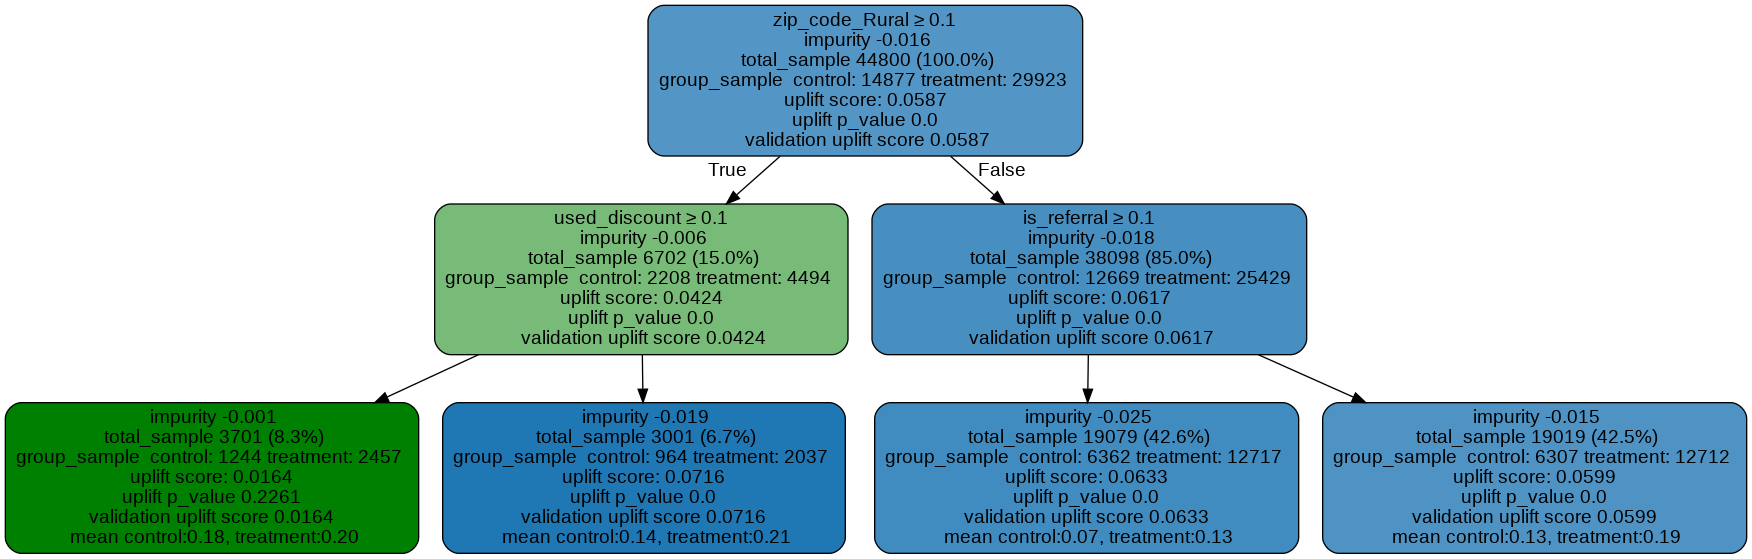

In [23]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())


### Тут я специально взял маленькую глубину дерева(3) чтобы проще интерпретировать листья. Результат разбиения в листьях будет некорректным и статистически слабым.

* 1 лист имеет довольно большое p_value ( > uplift_score), это можно интерпретировать как отсутствие статистически важных различий между двумя группами. Не стоит оказывать какое-либо воздействие на клиентов из этой группы
* 2 лист имеет p_value = 0, это хорошо, к пользователям этой группы следут применить воздействие, хоть она и довольно маленькая. Тут уже нужно смотреть на конверсию в денежном эквивалетне и оценивать.
* 3 и 4 листы аналогичны 2, к томе жу они покрывают практически всю нашу выборку(85%)

#### Пусть это и учебный пример, но если судить по конкретной модели,в идеальном мире этой задачи можно развернуть 91% оттока, что выглядит фантастически. Поэтому решение не претендует на решение впринципе)

#### Далее подход прост. Для каждого листа, который нас утроил, смотрим на уловия прихода дерева к этому листу и сортируем наши данные в аналогичном порядке.